<a href="https://colab.research.google.com/github/rajrohansinha/ATM_Dispense_Predictions/blob/main/Ticket_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [62]:
# import json
# import pandas as pd

# # Read the JSON file
# with open('C://Users//Raj.Rohan//OneDrive - Unilever//Desktop//Bits_pilani_Project//complaints-2021-05-14_08_16_.json', 'r') as json_file:
#     data = json.load(json_file)

# # Convert the JSON data to a DataFrame
# df = pd.json_normalize(data)

# # Specify the output CSV file name
# output_csv_file = "complaints_data.csv"

# # Convert the DataFrame to CSV
# df.to_csv(output_csv_file, index=False)

# print(f"CSV file '{output_csv_file}' created.")

### Problem statement

You need to build a model that is able to classify customer complaints raised in form of tickets based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the json data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into certain clusters based on their products/services:

With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

#### Importing necessary libraries

In [174]:
import pandas as pd
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
# import shap
import warnings
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
import plotly.express as px
from datetime import datetime
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from numpy import mean

# selection of algorithms to consider and set performance measure
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV, GridSearchCV

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from imblearn.over_sampling import SMOTE

from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import pickle
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

import re
import spacy
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [64]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [175]:
from google.colab import files

# Use the file picker to select the file
uploaded = files.upload()

# Get the uploaded file name
file_name = list(uploaded.keys())[0]

# Read the uploaded file
df = pd.read_csv(file_name)

Saving complaints_data.csv to complaints_data (3).csv


In [176]:
df.shape

(78313, 22)

#### Data fetching

In [177]:
#Assign new column names
df.columns = ['index', 'type', 'id', 'score', 'tags', 'zip_code','complaint_id', 'issue', 'date_received',
       'state', 'consumer_disputed', 'product','company_response', 'company', 'submitted_via',
       'date_sent_to_company', 'company_public_response','sub_product', 'timely',
       'complaint_what_happened', 'sub_issue','consumer_consent_provided']

#### Data Preprocessing

In [178]:
def check_data_quality(df):
    """
    Check the quality of a pandas DataFrame and remove irrelevant columns.
    """
    # Check for missing values
    missing_values = df.isnull().sum().sum()
    if missing_values > 0:
        print(f"WARNING: DataFrame contains {missing_values} missing values.")

    # Check for duplicate rows
    duplicate_rows = df.duplicated().sum()
    if duplicate_rows > 0:
        print(f"WARNING: DataFrame contains {duplicate_rows} duplicate rows.")

    # Identify and remove irrelevant columns
    irrelevant_columns = df.apply(lambda col: col.nunique() == 1)
    irrelevant_columns = irrelevant_columns[irrelevant_columns].index.tolist()
    if irrelevant_columns:
        print(f"Removing irrelevant columns: {irrelevant_columns}")
        df.drop(columns=irrelevant_columns, inplace=True)

In [179]:
check_data_quality(df)

Removing irrelevant columns: ['index', 'type', 'score', 'company']


In [180]:
df[df.loc[:, 'complaint_what_happened'] == ''] = np.nan

In [181]:
df = df[~df['complaint_what_happened'].isnull()] #Remove all rows where complaints column is nan
df['complaint_what_happened'] = df['complaint_what_happened'].astype(str)

In [182]:
columns_to_remove = ['tags', 'zip_code', 'consumer_disputed', 'company_public_response', 'sub_product']
df = df.drop(columns=columns_to_remove)

In [183]:
def preprocess_text(text):
    if isinstance(text, str):
        text = text.lower()
        text = re.sub(r'[^a-zA-Z\s]', ' ', text)  # Remove non-alphabetic characters
        text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
        words = text.split()
        stop_words = set(stopwords.words('english'))
        words = [word for word in words if word not in stop_words]
        lemmatizer = WordNetLemmatizer()
        words = [lemmatizer.lemmatize(word) for word in words]
        processed_text = ' '.join(words)
        return processed_text
    else:
        return ""

def remove_pos_tags(text):
    blob = TextBlob(text)
    pos_tags_removed = " ".join([word for (word, tag) in blob.tags if tag != 'xxxx'])  # Exclude 'xxxx' tags
    return pos_tags_removed

# Assuming you have defined the DataFrame 'df' before this point
df_clean = df[['complaint_id', 'complaint_what_happened']].copy()
df_clean['complaint_what_happened'] = df_clean['complaint_what_happened'].apply(preprocess_text)
df_clean['complaint_what_happened_no_pos'] = df_clean['complaint_what_happened'].apply(remove_pos_tags)

# Remove 'xxxx' strings from the cleaned text
df_clean['complaint_what_happened_no_pos'] = df_clean['complaint_what_happened_no_pos'].str.replace('xxxx', '')

### ----------------- Exploratory data analysis on raw data-------------------------------------------------------------------------------

#### 1. Feature - complaint_what_happened

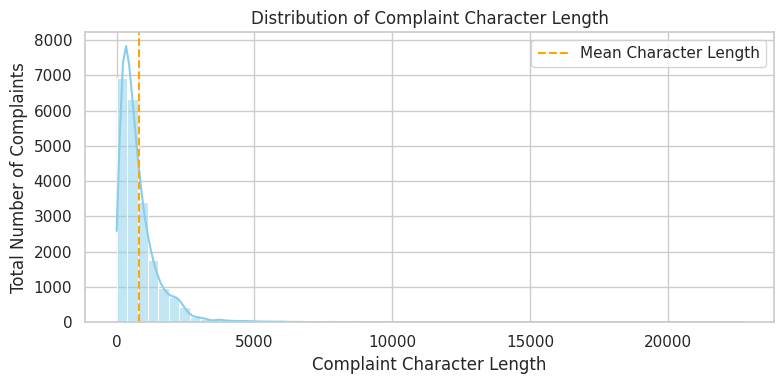

In [184]:
# Compute the character length for each complaint
char_len = [len(each_sent) for each_sent in df_clean['complaint_what_happened_no_pos']]

# Set the style of the plot
sns.set_theme(style="whitegrid", palette="pastel")

# Create the histogram plot
plt.figure(figsize=(8, 4))
sns.histplot(char_len, kde=True, bins=60, color='skyblue')

# Add a vertical line for the mean character length
mean_char_len = sum(char_len) / len(char_len)
plt.axvline(x=mean_char_len, color='orange', linestyle='--', label='Mean Character Length')

# Customize plot labels and title
plt.xlabel("Complaint Character Length")
plt.ylabel("Total Number of Complaints")
plt.title("Distribution of Complaint Character Length")

# Add legend
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

##### We can see that average character length of the complaints was around 1000 characters. Also the distribution is highly skewed.

##### Sentiment analysis on the complaints data

In [185]:
def analyze_sentiment(text):
    blob = TextBlob(text)
    sentiment = blob.sentiment.polarity
    if sentiment > 0:
        return 'Positive'
    elif sentiment < 0:
        return 'Negative'
    else:
        return 'Neutral'

# Apply sentiment analysis to a DataFrame column
df_clean['sentiment'] = df_clean['complaint_what_happened_no_pos'].apply(analyze_sentiment)

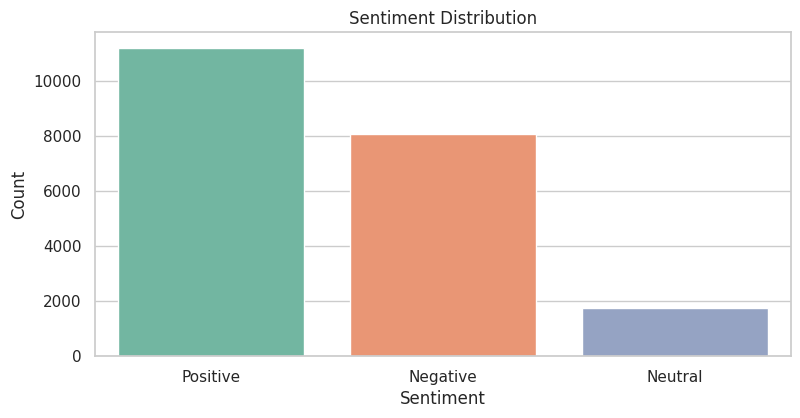

  Sentiment  Count
0  Positive  11214
1  Negative   8092
2   Neutral   1766


In [186]:
# Plot the sentiment distribution
sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 4))
sns.countplot(data=df_clean, x='sentiment', palette='Set2')
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.title("Sentiment Distribution")
plt.show()

# Create a table of sentiment counts
sentiment_counts = df_clean['sentiment'].value_counts().reset_index()
sentiment_counts.columns = ['Sentiment', 'Count']

# Display the sentiment counts table
print(sentiment_counts)

##### Positive Sentiment (Count: 11,214):

The majority of complaints exhibit a positive sentiment. This suggests that a significant portion of consumers are satisfied with their experiences or have encountered positive outcomes in their interactions.

##### Negative Sentiment (Count: 8,092):

There is a substantial number of complaints expressing negative sentiment. This indicates areas where consumers have encountered issues, challenges, or dissatisfaction with products, services, or interactions. These complaints could highlight areas for improvement in various aspects of business operations, such as customer service, product quality, or communication.

##### Neutral Sentiment (Count: 1,766):

A smaller proportion of complaints fall into the neutral sentiment category. These complaints may represent cases where consumers are providing feedback or reporting issues without conveying strong positive or negative emotions. Neutral sentiment complaints could include inquiries, general feedback, or reports of incidents with a relatively neutral tone.

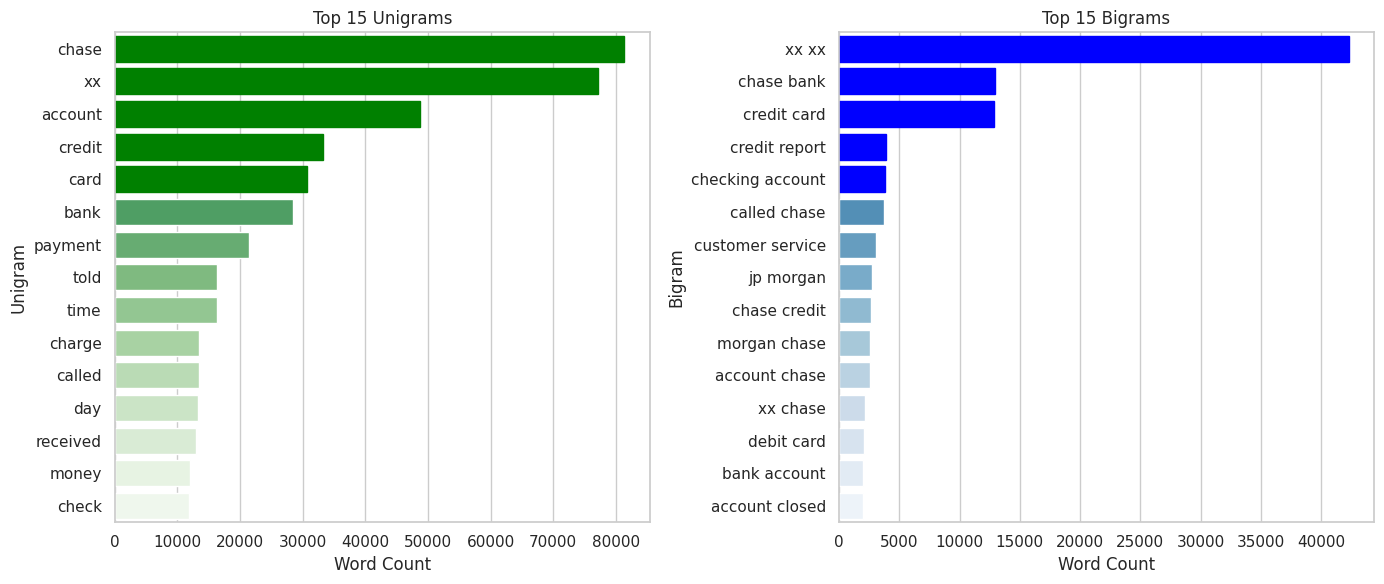

In [187]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def get_top_ngrams(text, n=None, ngram=(1,1)):
    vec = CountVectorizer(stop_words='english', ngram_range=ngram).fit(text)
    bagofwords = vec.transform(text)
    sum_words = bagofwords.sum(axis=0)
    words_frequency = [(word, sum_words[0, index]) for word, index in vec.vocabulary_.items()]
    words_frequency = sorted(words_frequency, key=lambda x: x[1], reverse=True)
    return words_frequency[:n]

# Unigrams
top_15unigrams = get_top_ngrams(df_clean['complaint_what_happened_no_pos'].values.astype('U'), n=15, ngram=(1, 1))
df_unigram = pd.DataFrame(top_15unigrams, columns=['ngram', 'count'])

# Bigrams
top_15bigrams = get_top_ngrams(df_clean['complaint_what_happened_no_pos'].values.astype('U'), n=15, ngram=(2, 2))
df_bigram = pd.DataFrame(top_15bigrams, columns=['ngram', 'count'])

# Set style and palette for the plots
sns.set_theme(style='whitegrid', palette='pastel')

# Create subplots for Unigrams and Bigrams
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Plot Unigrams
sns.barplot(x='count', y='ngram', data=df_unigram, palette='Greens_r', ax=axes[0])
axes[0].set_title('Top 15 Unigrams')
axes[0].set_xlabel('Word Count')
axes[0].set_ylabel('Unigram')
for i in range(5):
    axes[0].get_children()[i].set_color('green')

# Plot Bigrams
sns.barplot(x='count', y='ngram', data=df_bigram, palette='Blues_r', ax=axes[1])
axes[1].set_title('Top 15 Bigrams')
axes[1].set_xlabel('Word Count')
axes[1].set_ylabel('Bigram')
for i in range(5):
    axes[1].get_children()[i].set_color('blue')

# Adjust layout and display plots
plt.tight_layout()
plt.show()

The analysis of customer complaints reveals significant patterns and trends. The most prevalent concerns expressed by customers revolve around bank accounts, credit cards, and reports. Among these issues, the bank most frequently mentioned in complaints is JP Morgan Chase, indicating its prominence in customer grievances. This data underscores the significance of addressing these specific concerns to enhance customer satisfaction and loyalty.

#### 2. Feature - issue

,Issue,Total Count
0,Managing an account,2270
1,Problem with a purchase shown on your statement,1808
2,Incorrect information on your report,1202
3,"Other features, terms, or problems",753
4,Closing an account,747
5,"Loan servicing, payments, escrow account",654
6,Problem with a lender or other company charging your account,584
7,"Loan modification,collection,foreclosure",582
8,Problem with a credit reporting company's investigation into an existing problem,546
9,Trouble during payment process,526


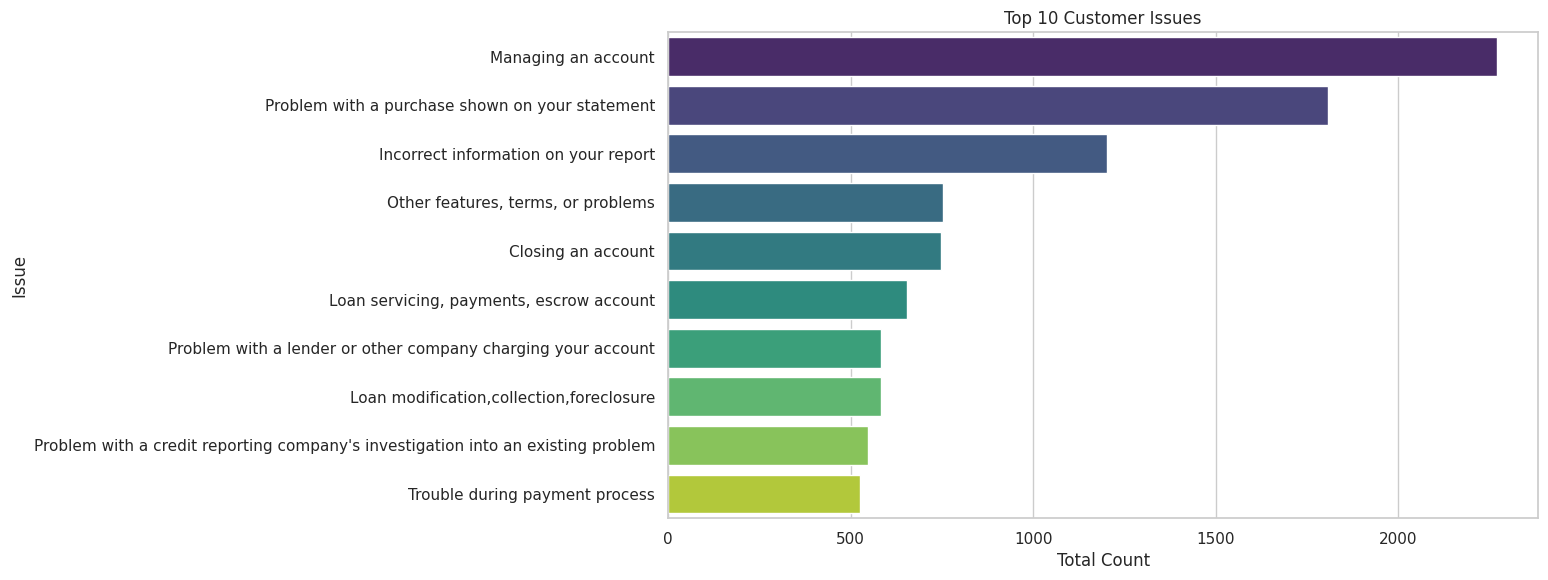

In [188]:
top_10_issues = df['issue'].value_counts().head(10)

# Generate a table with bold headers
top_10_table = pd.DataFrame({'Issue': top_10_issues.index, 'Total Count': top_10_issues.values})
top_10_table_styled = (
    top_10_table.style
    .applymap(lambda x: 'color: green' if x in top_10_table['Issue'][:3] else '')
    .set_properties(**{'font-weight': 'bold'}, subset=['Issue'])
)

# Display the styled table
display(top_10_table_styled)

# Create a bar graph
plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_issues.values, y=top_10_issues.index, palette='viridis')
plt.xlabel('Total Count')
plt.ylabel('Issue')
plt.title('Top 10 Customer Issues')
plt.show()


###### Managing an Account:
The most frequent customer concern is related to account management. Customers often encounter challenges or questions regarding their accounts, indicating a need for improved user interfaces, clearer instructions, and better support resources.

##### Problem with a Purchase:
This suggests potential discrepancies between purchase records and statements, emphasizing the importance of accurate transaction tracking.

##### Incorrect Information on Report:
Customers have also highlighted concerns about inaccuracies in their reports. This indicates a potential gap in data accuracy or reporting processes.

#### 3. Feature - Product

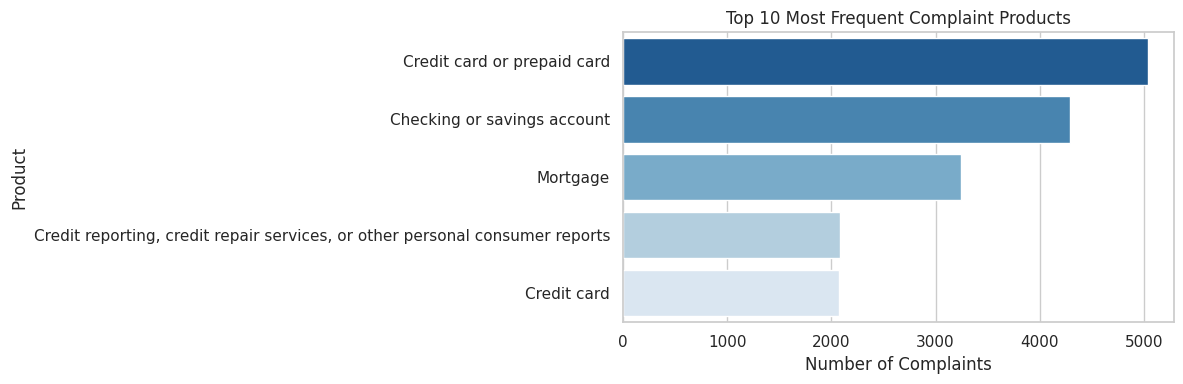

In [189]:
# Get the top 5 most frequent product categories
top_products = df['product'].value_counts().nlargest(5)

# Set style and palette for the plot
sns.set_theme(style='whitegrid', palette='pastel')

# Create the bar plot
plt.figure(figsize=(12, 4))
ax = sns.barplot(x=top_products.values, y=top_products.index, palette='Blues_r')

# Customize plot labels and title
plt.xlabel('Number of Complaints')
plt.ylabel('Product')
plt.title('Top 10 Most Frequent Complaint Products')

# Display the plot
plt.tight_layout()
plt.show()


#### 4. Looking at company responses for different category of customer complaints

In [190]:
# Create a subset of the data
subset = df[['company_response', 'product']]

# Get the top 5 product categories
top_products = subset['product'].value_counts().index[:10]

# Filter the data for the top 5 products
subset_top = subset[subset['product'].isin(top_products)]

# Create a contingency table (cross-tabulation)
contingency_table = pd.crosstab(subset_top['product'], subset_top['company_response'], margins=True)

# Remove the "All" row and column
contingency_table = contingency_table.iloc[:-1, :-1]

# Calculate the total column
contingency_table['Total'] = contingency_table.sum(axis=1)

# Set color map for highlighting numbers
cmap = sns.light_palette("blue", as_cmap=True)

# Highlight numbers based on specified criteria
def highlight_numbers(val):

    if 0 <= val <= 1000:
        color = 'background-color: yellow'
    else:
        color = 'background-color: lightgreen'
    return color

# Apply the highlight function and format to display count
styled_table = contingency_table.style.applymap(highlight_numbers).format('{:,}')

# Display the styled table
styled_table

company_response,Closed,Closed with explanation,Closed with monetary relief,Closed with non-monetary relief,Total
product,,,,,
Bank account or service,17,"1,164",452,17,"1,650"
Checking or savings account,0,"2,951","1,315",24,"4,290"
Consumer Loan,1,204,19,16,240
Credit card,4,"1,635",264,167,"2,070"
Credit card or prepaid card,0,"3,668",855,516,"5,039"
"Credit reporting, credit repair services, or other personal consumer reports",0,"1,461",30,596,"2,087"
Debt collection,0,835,35,85,955
"Money transfer, virtual currency, or money service",0,666,129,2,797
Mortgage,16,"3,038",154,38,"3,246"


###### closed with explaination

Issues related to credit/debit cards , mortage & savings accounts were mostly closed with explaination. In this scenario, the company has closed the complaint, but they have provided an explanation to the customer regarding the actions taken or the resolution provided.

###### Closed with monetary relief

For savings account issue the company has resolved the complaint by providing some form of monetary compensation or refund to the customer.

#### 5 - Dealing with complain/ticket receiving dates & finally sending it to the company (JP Morgan) to deal with them.

In [191]:
df['date_received'] = pd.to_datetime(df['date_received'])
df['date_sent_to_company'] = pd.to_datetime(df['date_sent_to_company'])

In [192]:
df['response_time'] = df['date_sent_to_company'] - df['date_received']

# Calculate average response time
average_response_time = df['response_time'].mean()

print(f"Average Response Time: {average_response_time}")

Average Response Time: 0 days 14:49:20.364464692


In [193]:
# Count complaints by day of the week
complaints_by_day_received = df.groupby(df['date_received'].dt.day_name())['date_received'].count()
complaints_by_day_sent = df.groupby(df['date_sent_to_company'].dt.day_name())['date_sent_to_company'].count()

# Create a DataFrame for the result
result_df = pd.DataFrame({
    'Day of the Week': complaints_by_day_received.index,
    'Complaints Received': complaints_by_day_received.values,
    'Complaints Sent to Company': complaints_by_day_sent.values
})

# Calculate the difference column
result_df['Difference'] = result_df['Complaints Received'] - result_df['Complaints Sent to Company']

# Display the result table
result_df

,Day of the Week,Complaints Received,Complaints Sent to Company,Difference
0,Friday,3404,3403,1
1,Monday,3173,3217,-44
2,Saturday,1999,1873,126
3,Sunday,1500,1376,124
4,Thursday,3544,3616,-72
5,Tuesday,3811,3842,-31
6,Wednesday,3641,3745,-104


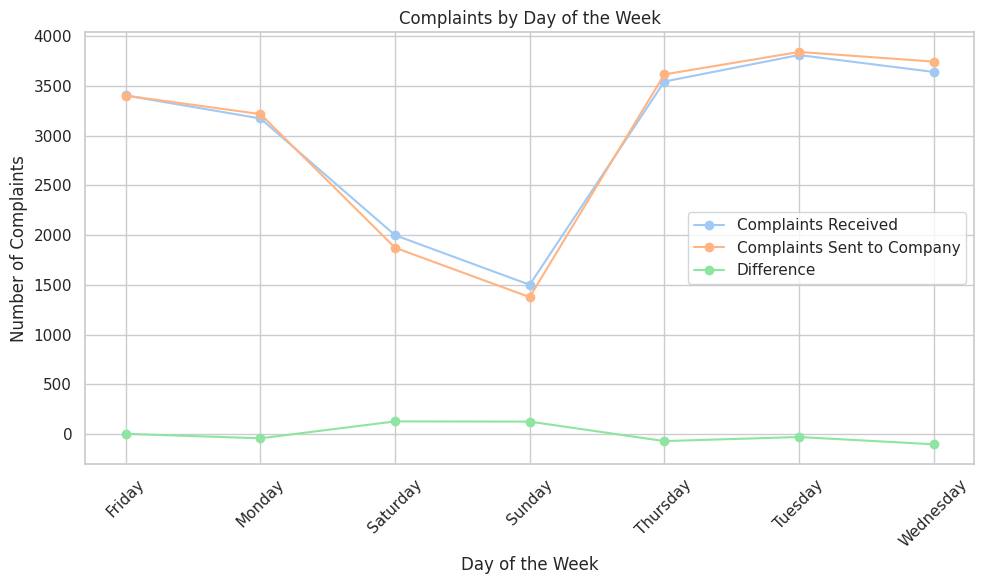

In [194]:
# Plotting multiple line charts
plt.figure(figsize=(10, 6))

plt.plot(result_df['Day of the Week'], result_df['Complaints Received'], marker='o', label='Complaints Received')
plt.plot(result_df['Day of the Week'], result_df['Complaints Sent to Company'], marker='o', label='Complaints Sent to Company')
plt.plot(result_df['Day of the Week'], result_df['Difference'], marker='o', label='Difference')

plt.title('Complaints by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Complaints')
plt.xticks(rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

Weekends show a positive difference, indicating that more complaints are received compared to the complaints sent to the company. This trend suggests that customers engage actively with the complaint submission process on Saturdays.

Monday till Thursday exhibit negative differences, indicating that more complaints are sent to the company than received. This could be due to effective resolution strategies in place on these days.

Fridays have the smallest difference of 1, implying a nearly equal number of complaints received and sent. This could indicate a precise and efficient handling of complaints at the end of the week.

### ---------------------Data cleaning/preprocessing-----------------------------------------------------------------------------------------

#### 1. Dealing with null values

In [195]:
def find_missing_percent(data):
    """
    Returns dataframe containing the total missing values and percentage of total
    missing values of a column.
    """
    miss_df = pd.DataFrame({'ColumnName':[],'TotalMissingVals':[],'PercentMissing':[]})
    for col in data.columns:
        sum_miss_val = data[col].isnull().sum()
        percent_miss_val = round((sum_miss_val/data.shape[0])*100,2)
        miss_df = miss_df.append(dict(zip(miss_df.columns,[col,sum_miss_val,percent_miss_val])),ignore_index=True)
    return miss_df

In [196]:
columns_to_remove = ['sub_issue','timely','submitted_via','consumer_consent_provided']
df = df.drop(columns=columns_to_remove)

In [197]:
# Calculate the mode of the 'state' column
mode_state = df['state'].mode()[0]
# Replace null values with the mode
df['state'].fillna(mode_state, inplace=True)

In [198]:
miss_df = find_missing_percent(df)
miss_df

,ColumnName,TotalMissingVals,PercentMissing
0,id,0.0,0.0
1,complaint_id,0.0,0.0
2,issue,0.0,0.0
3,date_received,0.0,0.0
4,state,0.0,0.0
5,product,0.0,0.0
6,company_response,0.0,0.0
7,date_sent_to_company,0.0,0.0
8,complaint_what_happened,0.0,0.0
9,response_time,0.0,0.0


#### 2.Dealing with categorical variables

In [199]:
State_list = []
for i in df.state:
    if i == 'CA':
        State_list.append('CA')
    elif i == 'NY':
        State_list.append('NY')
    elif i == 'TX':
        State_list.append('TX')
    else:
        State_list.append('Others')
df['state'] = State_list

In [200]:
Product_list = []
for i in df['product']:
    if i == 'Credit card or prepaid card':
        Product_list.append('Credit card or prepaid card')
    elif i == 'Checking or savings account':
        Product_list.append('Checking or savings account')
    elif i == 'Mortgage':
        Product_list.append('Mortgage')
    elif i == 'Credit reporting, credit repair services, or other personal consumer reports':
        Product_list.append('Credit reporting, credit repair services, or other personal consumer reports')
    else:
        Product_list.append('Other product complaints')

# Add the 'Product' list as a new column to the DataFrame
df['product'] = Product_list

In [201]:
def create_dummy_variables(data, columns):
    # Create dummies for specified columns
    dummies = pd.get_dummies(data[columns], prefix=columns, drop_first=True)

    # Concatenate dummies with the original DataFrame
    data = pd.concat([data, dummies], axis=1)

    # Drop the original columns
    data.drop(columns, axis=1, inplace=True)

    return data

# List of columns for which to create dummy variables
dummy_columns = ['state', 'product', 'company_response']

# Call the function to create dummy variables and remove original columns
df = create_dummy_variables(df, dummy_columns)

In [202]:
merged_df = pd.merge(df_clean, df, on='complaint_id', how='inner')
merged_df['complaint_what_happened'] = merged_df['complaint_what_happened_x']

# Drop unnecessary columns
columns_to_drop = ['complaint_what_happened_x', 'complaint_what_happened_y']
merged_df.drop(columns=columns_to_drop, inplace=True)

###Document-Term Matrix (DTM) Generation

In [203]:
from sklearn.feature_extraction.text import TfidfVectorizer

def create_document_term_matrix(data, min_df=2, max_df=0.95, stop_words='english'):
    """
    Create a TF-IDF Document-Term Matrix (DTM) from text data.

    Args:
    data (list or Series): The text data to vectorize.
    min_df (int or float, optional): Minimum document frequency for terms.
    max_df (int or float, optional): Maximum document frequency for terms.

    Returns:
    csr_matrix: A sparse CSR matrix representing the TF-IDF DTM.
    TfidfVectorizer: The fitted TfidfVectorizer instance.
    """

    # Initialize the TfidfVectorizer with specified parameters
    tfidf = TfidfVectorizer(min_df=min_df, max_df=max_df, stop_words=stop_words)

    # Fit and transform the data to create the DTM
    dtm = tfidf.fit_transform(data)

    return dtm, tfidf

In [204]:
dtm, tfidf_vectorizer = create_document_term_matrix(merged_df['complaint_what_happened_no_pos'])

### Topic modelling to assign topics to relevant complaints.

In [205]:
from sklearn.decomposition import LatentDirichletAllocation

def create_lda_topic_model(dtm, num_topics=5, random_state=40):

    # Initialize the LDA model with specified parameters
    lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=random_state)

    # Fit the LDA model to the DTM
    document_topics = lda_model.fit_transform(dtm)

    # Get the best topic for each document
    best_topics = document_topics.argmax(axis=1)

    return pd.Series(best_topics), lda_model

# Create the LDA topic model on top of the TF-IDF DTM
best_topics_lda, lda_model = create_lda_topic_model(dtm)

In [206]:
feature_names = tfidf_vectorizer.get_feature_names_out()
feature_names

array(['aa', 'aaa', 'aarp', ..., 'zombie', 'zone', 'zoom'], dtype=object)

In [207]:
import pandas as pd
from tabulate import tabulate

# Function to create a table of top words for all topics
def create_top_words_table(lda_model, feature_names, num_topics=5, n_words=10):
    top_words_table = pd.DataFrame(columns=[f'Topic {i + 1}' for i in range(num_topics)])

    for topic_id, topic_words in enumerate(lda_model.components_):
        top_word_indices = topic_words.argsort()[-n_words:][::-1]
        top_words = [feature_names[i] for i in top_word_indices]
        top_words_table[f'Topic {topic_id + 1}'] = top_words

    return top_words_table

# Assuming you have previously defined your LDA model 'lda_model'
# and your feature names 'feature_names' from the DTM
# Create the top words table
top_words_table = create_top_words_table(lda_model, feature_names)

# Display the table
print(tabulate(top_words_table, headers='keys', tablefmt='psql'))

+----+-----------+-----------+-------------+-----------+-----------+
|    | Topic 1   | Topic 2   | Topic 3     | Topic 4   | Topic 5   |
|----+-----------+-----------+-------------+-----------+-----------|
|  0 | xx        | bonus     | xx          | inquiry   | account   |
|  1 | payment   | offer     | card        | hard      | xx        |
|  2 | chase     | promotion | chase       | report    | chase     |
|  3 | credit    | point     | charge      | credit    | bank      |
|  4 | loan      | credit    | credit      | xx        | check     |
|  5 | mortgage  | chase     | dispute     | jpmcb     | money     |
|  6 | card      | xx        | account     | inquires  | fund      |
|  7 | account   | reporting | transaction | removed   | told      |
|  8 | late      | card      | merchant    | authorize | deposit   |
|  9 | balance   | account   | fraud       | remove    | checking  |
+----+-----------+-----------+-------------+-----------+-----------+


**Understanding the different categories of complains from customers.**

Topic 1 - Mortages/Loan complains

Topic 2 - Promotional offers complains

Topic 3 - Fraud/Theft complains

Topic 4 - Inquiry complains

Topic 5 - Bank Account/Funds/Money

In [208]:
# Create the "topic" column and add the LDA topic assignments to it
merged_df['topic'] = best_topics_lda

In [209]:
# Define a mapping of LDA topic assignments to actual topics
topic_mapping = {
    0: "Mortgages/Loan complaints",
    1: "Promotional offers complaints",
    2: "Fraud/Theft complaints",
    3: "Inquiry complaints",
    4: "Bank Account/Funds/Money",
}

# Map the LDA topic assignments to actual topics and add them to the "topic" column
merged_df['topic'] = merged_df['topic'].map(topic_mapping)

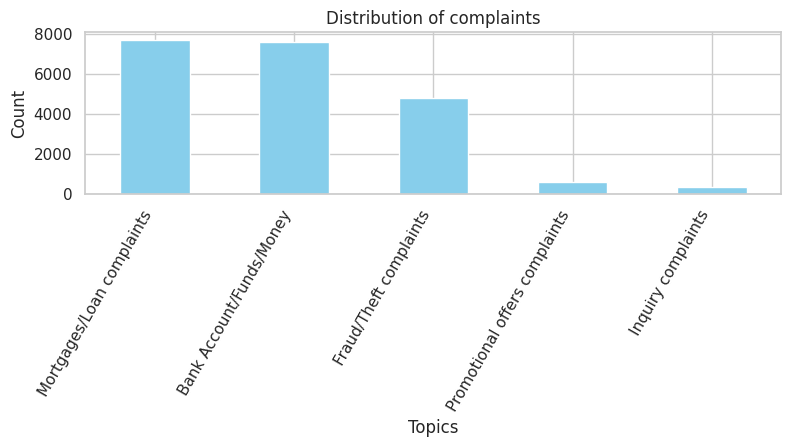

Mortgages/Loan complaints        7712
Bank Account/Funds/Money         7633
Fraud/Theft complaints           4789
Promotional offers complaints     596
Inquiry complaints                342
Name: topic, dtype: int64

In [210]:
topic_counts = merged_df['topic'].value_counts()

plt.figure(figsize=(8, 2))
topic_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of complaints')
plt.xlabel('Topics')
plt.ylabel('Count')
plt.xticks(rotation=60, ha='right')
plt.tight_layout()
plt.show()

merged_df['topic'].value_counts()

###Preprocessing columns before modelling

In [212]:
le = LabelEncoder()
merged_df['sentiment'] = le.fit_transform(merged_df['sentiment'])
merged_df['response_time'] = merged_df['response_time'].astype(str).str.replace('days','')

In [213]:
Training_Columns = ['complaint_what_happened_no_pos', 'sentiment','response_time',
       'state_NY', 'state_Others', 'state_TX',
       'product_Credit card or prepaid card',
       'product_Credit reporting, credit repair services, or other personal consumer reports',
       'product_Mortgage', 'product_Other product complaints',
       'company_response_Closed with explanation',
       'company_response_Closed with monetary relief',
       'company_response_Closed with non-monetary relief', 'topic']

In [214]:
Filtered_df = merged_df[Training_Columns]

In [218]:
from sklearn.feature_extraction.text import TfidfVectorizer
text_data = merged_df['complaint_what_happened_no_pos']
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
text_features = tfidf_vectorizer.fit_transform(text_data)
text_features_df = pd.DataFrame(text_features.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

selected_columns = ['sentiment','response_time',
       'state_NY', 'state_Others', 'state_TX',
       'product_Credit card or prepaid card',
       'product_Credit reporting, credit repair services, or other personal consumer reports',
       'product_Mortgage', 'product_Other product complaints',
       'company_response_Closed with explanation',
       'company_response_Closed with monetary relief',
       'company_response_Closed with non-monetary relief']

X = pd.concat([text_features_df, Filtered_df[selected_columns]], axis=1) # Feature data

y = le.fit_transform(Filtered_df['topic']) # Target labels

In [219]:
# Get the mapping of numerical labels to topic names
label_mapping = dict(zip(range(len(le.classes_)), le.classes_))

# Print the mapping
for label, topic in label_mapping.items():
    print(f"Label {label} is associated with topic: {topic}")

Label 0 is associated with topic: Bank Account/Funds/Money
Label 1 is associated with topic: Fraud/Theft complaints
Label 2 is associated with topic: Inquiry complaints
Label 3 is associated with topic: Mortgages/Loan complaints
Label 4 is associated with topic: Promotional offers complaints


### Handling data imbalance

In [222]:
from imblearn.over_sampling import RandomOverSampler
oversampler = RandomOverSampler(random_state=42)
train_X_resampled, train_y_resampled = oversampler.fit_resample(X, y) # Fit and transform the data

### Split resampled data into train & validation sets

In [225]:
train_X, validation_X, train_Y, validation_Y = train_test_split(train_X_resampled, train_y_resampled, test_size=0.25, random_state=42)

### Model creation

In [226]:
def evaluate_model(model, x_validation, y_validation):
    from sklearn import metrics

    # Predict validation data
    y_pred = model.predict(x_validation)

    # Calculate accuracy, precision, recall, f1-score.
    acc = metrics.accuracy_score(y_validation, y_pred)
    prec = metrics.precision_score(y_validation, y_pred, average='weighted')
    rec = metrics.recall_score(y_validation, y_pred, average='weighted')
    f1 = metrics.f1_score(y_validation, y_pred, average='weighted')

    # Calculate area under curve (AUC)
    y_pred_proba = model.predict_proba(x_validation)
    auc = metrics.roc_auc_score(y_validation, y_pred_proba, multi_class='ovr')

    # Display confusion matrix
    cm = metrics.confusion_matrix(y_validation, y_pred)

    return {'acc': acc, 'prec': prec, 'rec': rec, 'f1': f1, 'auc': auc, 'cm': cm}

In [227]:
from sklearn import tree
dtc = tree.DecisionTreeClassifier(random_state=0)
dtc.fit(train_X, train_Y)

# Evaluate Model
dtc_eval = evaluate_model(dtc,validation_X, validation_Y)

# Print result
print('Accuracy:', dtc_eval['acc'])
print('Precision:', dtc_eval['prec'])
print('Recall:', dtc_eval['rec'])
print('F1 Score:', dtc_eval['f1'])
print('Area Under Curve:', dtc_eval['auc'])
print('Confusion Matrix:\n', dtc_eval['cm'])

Accuracy: 0.8534232365145228
Precision: 0.8501879923139668
Recall: 0.8534232365145228
F1 Score: 0.8508657860147623
Area Under Curve: 0.9079859272109949
Confusion Matrix:
 [[1309  240    8  274   52]
 [ 143 1584   10  125   24]
 [   0    0 1939    0    0]
 [ 257  195   19 1439   63]
 [   3    0    0    0 1956]]


In [228]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(train_X, train_Y)

# Evaluate Model
knn_eval = evaluate_model(knn, validation_X, validation_Y)

# Print result
print('Accuracy:', knn_eval['acc'])
print('Precision:', knn_eval['prec'])
print('Recall:', knn_eval['rec'])
print('F1 Score:', knn_eval['f1'])
print('Area Under Curve:', knn_eval['auc'])
print('Confusion Matrix:\n', knn_eval['cm'])

Accuracy: 0.833091286307054
Precision: 0.8294289441129298
Recall: 0.833091286307054
F1 Score: 0.8289908449288943
Area Under Curve: 0.9487795609481507
Confusion Matrix:
 [[1328  281   25  181   68]
 [ 216 1403   71  108   88]
 [   0    0 1939    0    0]
 [ 181  225   50 1402  115]
 [   0    0    0    0 1959]]


In [233]:
rf = RandomForestClassifier(n_estimators=100, random_state=7)
rf.fit(train_X, train_Y)

# Evaluate Model
rf_eval = evaluate_model(rf, validation_X, validation_Y)

# Print result
print('Accuracy:', rf_eval['acc'])
print('Precision:', rf_eval['prec'])
print('Recall:', rf_eval['rec'])
print('F1 Score:', rf_eval['f1'])
print('Area Under Curve:', rf_eval['auc'])
print('Confusion Matrix:\n', rf_eval['cm'])

Accuracy: 0.9179460580912863
Precision: 0.9174157801653836
Recall: 0.9179460580912863
F1 Score: 0.9173029447038229
Area Under Curve: 0.9898801104041575
Confusion Matrix:
 [[1513  161    7  194    8]
 [ 108 1692   11   66    9]
 [   0    0 1939    0    0]
 [ 109  101    8 1746    9]
 [   0    0    0    0 1959]]


In [231]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(learning_rate=0.1)
gb.fit(train_X, train_Y)

# Evaluate Model
gb_eval = evaluate_model(gb, validation_X, validation_Y)

# Print result
print('Accuracy:', gb_eval['acc'])
print('Precision:', gb_eval['prec'])
print('Recall:', gb_eval['rec'])
print('F1 Score:', gb_eval['f1'])
print('Area Under Curve:', gb_eval['auc'])
print('Confusion Matrix:\n', gb_eval['cm'])

Accuracy: 0.8758298755186722
Precision: 0.8738420458613425
Recall: 0.8758298755186722
F1 Score: 0.8742336820823964
Area Under Curve: 0.9776260676729904
Confusion Matrix:
 [[1490  177   23  137   56]
 [ 167 1484   61   82   92]
 [   0    0 1939    0    0]
 [ 108  100   30 1664   71]
 [   6   35    0   52 1866]]


In [232]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(train_X, train_Y)
# Evaluate Model
lr_eval = evaluate_model(lr, validation_X, validation_Y)
# Print result
print('Accuracy:', lr_eval['acc'])
print('Precision:', lr_eval['prec'])
print('Recall:', lr_eval['rec'])
print('F1 Score:', lr_eval['f1'])
print('Area Under Curve:', lr_eval['auc'])
print('Confusion Matrix:\n', lr_eval['cm'])

Accuracy: 0.9002074688796681
Precision: 0.8992011282270149
Recall: 0.9002074688796681
F1 Score: 0.8992322849268147
Area Under Curve: 0.9869569305743582
Confusion Matrix:
 [[1574  137   12  111   49]
 [ 137 1569   45   50   85]
 [   0    0 1926   13    0]
 [ 103   67   21 1718   64]
 [   7   24   18   19 1891]]


### Model Comparison

In [235]:
import pandas as pd

# Evaluation Metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
models = ['Decision Tree', 'Random Forest', 'K-Nearest Neighbors', 'Gradient Boosting Classifier', 'Logistic Regression Classifier']
scores = [dtc_score, rf_score, knn_score, gb_score, lr_score]

# Create a DataFrame
df = pd.DataFrame(scores, columns=metrics, index=models)

# Apply styling to the DataFrame
df_styled = df.style.background_gradient(cmap='Blues').format("{:.2f}")

# Set table caption
caption = 'Model Comparison - Evaluation Metrics'

# Display the styled DataFrame with caption
display(df_styled.set_caption(caption))

,Accuracy,Precision,Recall,F1
Decision Tree,0.85,0.85,0.85,0.85
Random Forest,0.92,0.92,0.92,0.92
K-Nearest Neighbors,0.83,0.83,0.83,0.83
Gradient Boosting Classifier,0.88,0.87,0.88,0.87
Logistic Regression Classifier,0.90,0.90,0.90,0.90


Based on these metrics, Random Forest appears to be a good choice as it consistently performs well across multiple evaluation metrics. It achieves a good balance between accuracy, precision, recall, and F1 score.

### Hyperparameter Tuning

In [236]:
# Perform Randomized Search to find the best hyperparameters
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}
random_search = RandomizedSearchCV(rf, param_dist, n_iter=10, scoring='accuracy', cv=5, random_state=0)
random_search.fit(train_X, train_Y)

# Get the best hyperparameters and the corresponding model
best_params = random_search.best_params_
best_model = random_search.best_estimator_

# Train the best model on the training data
best_model.fit(train_X, train_Y)

# Evaluate the best model on the validation data
y_pred_best = best_model.predict(validation_X)
acc_best = accuracy_score(validation_Y, y_pred_best)
prec_best = precision_score(validation_Y, y_pred_best, average='weighted')
rec_best = recall_score(validation_Y, y_pred_best, average='weighted')
f1_best = f1_score(validation_Y, y_pred_best, average='weighted')
y_pred_proba_best = best_model.predict_proba(validation_X)
auc_best = roc_auc_score(validation_Y, y_pred_proba_best, multi_class='ovr')
cm_best = confusion_matrix(validation_Y, y_pred_best)

# Print evaluation results of the best model
print('Best Model Evaluation Results:')
print('Accuracy:', acc_best)
print('Precision:', prec_best)
print('Recall:', rec_best)
print('F1 Score:', f1_best)
print('Area Under Curve:', auc_best)
print('Confusion Matrix:\n', cm_best)

Best Model Evaluation Results:
Accuracy: 0.9191908713692946
Precision: 0.9185842328005428
Recall: 0.9191908713692946
F1 Score: 0.9184346738980291
Area Under Curve: 0.989746430559929
Confusion Matrix:
 [[1514  167    9  183   10]
 [ 101 1709   12   52   12]
 [   0    0 1939    0    0]
 [ 107  100   13 1740   13]
 [   0    0    0    0 1959]]


### Model Comparison - Baseline VS Tuned

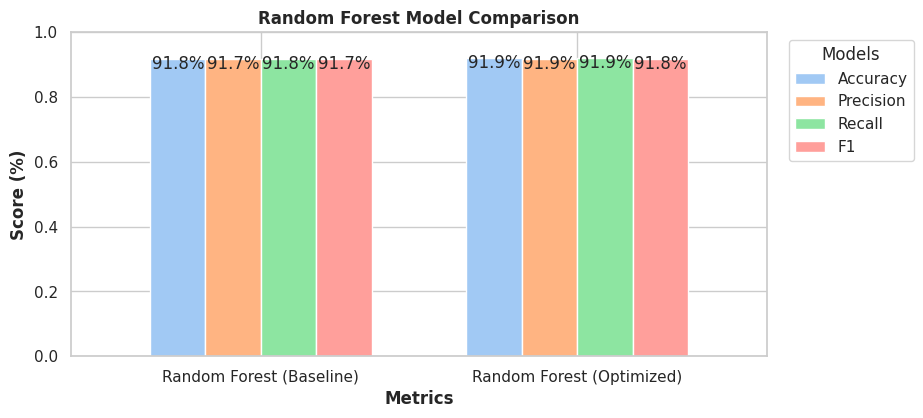

In [237]:
import pandas as pd
import matplotlib.pyplot as plt

# Evaluate the best model on the validation data
best_model_eval = evaluate_model(best_model, validation_X, validation_Y)

# Evaluation Metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
models = ['Random Forest (Baseline)', 'Random Forest (Optimized)']
scores = [rf_eval['acc'], rf_eval['prec'], rf_eval['rec'], rf_eval['f1']]
optimized_scores = [best_model_eval['acc'], best_model_eval['prec'], best_model_eval['rec'], best_model_eval['f1']]

# Create a DataFrame
df = pd.DataFrame([scores, optimized_scores], columns=metrics, index=models)

# Set figure size and background color
fig, ax = plt.subplots(figsize=(8, 4))
fig.set_facecolor('white')

# Plot the data
df.plot(kind='bar', ax=ax, width=0.7)

# Set plot properties
ax.set_xlabel('Metrics', fontweight='bold')
ax.set_ylabel('Score (%)', fontweight='bold')
ax.set_xticklabels(models, rotation=0)
ax.set_ylim(0, 1)
ax.set_title('Random Forest Model Comparison', fontsize=12, fontweight='bold')

# Add percentage labels on top of each bar
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    ax.annotate(f'{height*100:.1f}%', (x + width / 2, y + height),
                ha='center', va='bottom', xytext=(0, -10), textcoords='offset points')

# Adjust legend position
ax.legend(title='Models', bbox_to_anchor=(1.02, 1), loc='upper left')

plt.show()